In [1]:
# import os
# import time
# import itertools

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# import torch
# from torch import nn, optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# from torch.utils.data.dataset import Subset
# import torchvision
# from torchvision import datasets, transforms
# from torchvision.transforms import Compose, ToTensor, Normalize
# from torchvision.datasets import MNIST

In [2]:
from scripts.utils import *
from scripts.tensorboard import *
from scripts.dataloaders import *
from scripts.trainers import *

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [4]:
params = {
    'train_batch_size': 64,
    'val_batch_size': 64,
    'epochs': 2,
    'lr': 1e-3,
    'verbose': True,
    'tensorboard': False,
    'log_interval': 100,
    'log_dir': './tensorboard_logs',
    'model_name': 'LeNet',
    'model': CNN(),
    'criterion': nn.NLLLoss(),
    'optimizer': optim.Adam,
    'early_stopping': True,
    'early_stopping_patience': 11,
    'lr_patience': 5,
    'lr_factor': 0.25,
    'min_lr': 1e-5,
    
}

In [5]:
# %%time
# model, optimizer, scheduler, stats = train(params, get_MNIST_data_loaders)

In [6]:
# plot_stats(stats)

In [7]:
# %%time
# model, optimizer, scheduler, stats = continue_training(model, params, get_MNIST_data_loaders, stats, scheduler, optimizer, 
#                   new_params={
#                       'epochs': 2,
#                   })

In [8]:
# plot_stats(stats)

In [9]:
# model = CNN()
# model.load_state_dict(torch.load('./tensorboard_logs/MNIST/saved_models/MNIST_LeNet_lr:0.001_Adam_NLLLoss_37520.pth'))

In [10]:
train_loader, val_loader, holdout_loader, dataset_name, class_count = get_Arctic_data_loaders(8, 8, share=1.0)

In [11]:
len(train_loader)

217

In [12]:
len(val_loader)

73

In [13]:
len(holdout_loader)

73

tensor([4, 1, 3, 4, 3, 1, 4, 2])


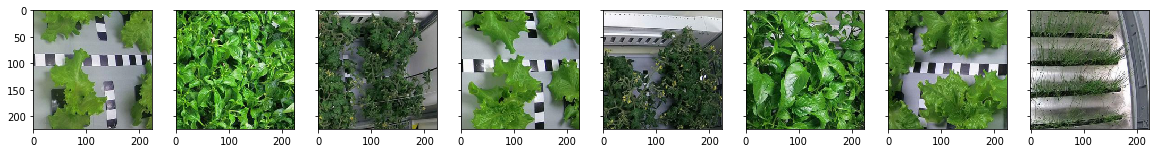

In [14]:
show_batch(train_loader)